In [39]:
# Import required libraries
import pandas as pd
import numpy as np
import os
import warnings
import sys

# Machine Learning Libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import sklearn

# Visualization Libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Configure settings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
pd.options.mode.copy_on_write = True
sklearn.set_config(transform_output="pandas")

# Configure matplotlib
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
sns.set()

# Suppress additional warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

print("✅ All libraries imported and configured successfully!")


✅ All libraries imported and configured successfully!


# 1. Data Loading and Preparation

This section handles loading the dataset files and preparing them for analysis.

In [40]:
# Load all CSV files from the dataset directory
files = [file for file in os.listdir('./dataset_looker')]
collection = []
for file in files:
    collection.append(file.rsplit('.', 1)[0])

# Create dictionary to store all dataframes
df = {}
for name in collection:
    df_single = pd.read_csv("./dataset_looker/" + name + ".csv")
    df[name] = df_single
    print(f"✅ Loaded {name}.csv with {len(df_single)} rows")

print(f"\n📊 Total datasets loaded: {len(df)}")

✅ Loaded distribution_centers.csv with 10 rows
✅ Loaded orders.csv with 125226 rows
✅ Loaded order_items.csv with 181759 rows
✅ Loaded products.csv with 29120 rows
✅ Loaded users.csv with 100000 rows

📊 Total datasets loaded: 5


In [41]:
# --- Create a function to convert data for dataset ---
def convert_dates_robustly(date_series):
    """
    Converts a pandas Series of date strings to datetime objects,
    handling multiple formats (with and without microseconds).

    Args:
        date_series (pd.Series): The column containing date strings.

    Returns:
        pd.Series: The converted column with datetime objects.
    """
    # Define the two different formats we've seen in the data
    format_with_micros = '%Y-%m-%d %H:%M:%S.%f%z'
    format_without_micros = '%Y-%m-%d %H:%M:%S%z'

    # Pass 1: Try converting everything using automatic detection, which is fast.
    converted_series = pd.to_datetime(date_series, errors='coerce', utc=True)
    
    # Pass 2: For any rows that failed, try the specific formats.
    failed_mask = converted_series.isna()
    if failed_mask.any():
        # On the failed rows ONLY, try the format with microseconds
        pass2_micros = pd.to_datetime(date_series[failed_mask], format=format_with_micros, errors='coerce')
        converted_series.update(pass2_micros)

        # Update the failed mask and try the format without microseconds
        failed_mask = converted_series.isna()
        if failed_mask.any():
            pass3_no_micros = pd.to_datetime(date_series[failed_mask], format=format_without_micros, errors='coerce')
            converted_series.update(pass3_no_micros)

    return converted_series

## 1.1 Data Merging and Feature Engineering

Merge multiple datasets and create relevant features for customer analysis.

In [42]:
# Add prefixes to column names for clarity
order_items = df['order_items'].add_prefix('order_items_')
products = df['products'].add_prefix('products_')
users = df['users'].add_prefix('users_')

# Merge order_items with products on product_id
merged = pd.merge(
    order_items,
    products,
    left_on='order_items_product_id',
    right_on='products_id',
    how='left'
)

# Merge the result with users on user_id
combine_df = pd.merge(
    merged,
    users,
    left_on='order_items_user_id',
    right_on='users_id',
    how='left'
)

print(f"✅ Merged dataset created with {len(combine_df)} rows and {len(combine_df.columns)} columns")

# Convert date columns to datetime objects
date_cols = ['order_items_created_at', 'order_items_shipped_at',
             'order_items_delivered_at', 'order_items_returned_at', 'users_created_at']

for col in date_cols:
    if col in combine_df.columns:
        print(f"Converting '{col}' to datetime...")
        combine_df[col] = convert_dates_robustly(combine_df[col])
        # Handle any NaT values that still exist after conversion
        if combine_df[col].isnull().any():
            print(f"Filling {combine_df[col].isnull().sum()} missing/invalid dates in '{col}' with median.")
            median_date = combine_df[col].median()
            combine_df[col].fillna(median_date, inplace=True)
    else:
        print(f"Warning: Date column '{col}' not found in the dataframe.")

# Clean up unused columns
columns_to_drop = [
    'order_items_id', 'order_items_user_id', 'order_items_inventory_item_id',
    'order_items_product_id', 'order_items_shipped_at', 'order_items_delivered_at',
    'order_items_returned_at', 'users_email', 'users_street_address',
    'users_first_name', 'users_last_name', 'users_postal_code',
    'products_sku', 'products_retail_price', 'products_name',
    'products_distribution_center_id', 'products_id'
]

combine_df = combine_df.drop(columns=columns_to_drop)
print(f"✅ Removed {len(columns_to_drop)} unnecessary columns")

✅ Merged dataset created with 181759 rows and 35 columns
Converting 'order_items_created_at' to datetime...
Converting 'order_items_shipped_at' to datetime...
Filling 63478 missing/invalid dates in 'order_items_shipped_at' with median.
Converting 'order_items_delivered_at' to datetime...
Filling 117918 missing/invalid dates in 'order_items_delivered_at' with median.
Converting 'order_items_returned_at' to datetime...
Filling 163527 missing/invalid dates in 'order_items_returned_at' with median.
Converting 'users_created_at' to datetime...
✅ Removed 17 unnecessary columns


In [43]:
# Check the final merged dataset structure
print("📊 Final merged dataset information:")
combine_df.info()

📊 Final merged dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181759 entries, 0 to 181758
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   order_items_order_id    181759 non-null  int64              
 1   order_items_status      181759 non-null  object             
 2   order_items_created_at  181759 non-null  datetime64[ns, UTC]
 3   order_items_sale_price  181759 non-null  float64            
 4   products_cost           181759 non-null  float64            
 5   products_category       181759 non-null  object             
 6   products_brand          181610 non-null  object             
 7   products_department     181759 non-null  object             
 8   users_id                181759 non-null  int64              
 9   users_age               181759 non-null  int64              
 10  users_gender            181759 non-null  object         

In [44]:
# Check for missing values in the dataset
print("🔍 Missing values summary:")
missing_values = combine_df.isna().sum()
print(missing_values[missing_values > 0])

🔍 Missing values summary:
products_brand     149
users_city        1681
dtype: int64


In [45]:
# Feature Engineering: Create profit column
combine_df['profit'] = combine_df['order_items_sale_price'] - combine_df['products_cost']

# Analyze order status distribution
print("📈 Order Status Distribution:")
print(combine_df['order_items_status'].value_counts())
print("\n" + "="*50 + "\n")

# Analyze customer countries
print("🌍 Customer Country Distribution:")
print(combine_df['users_country'].value_counts())



📈 Order Status Distribution:
order_items_status
Shipped       54440
Complete      45609
Processing    36388
Cancelled     27090
Returned      18232
Name: count, dtype: int64


🌍 Customer Country Distribution:
users_country
China             62708
United States     40571
Brasil            26428
South Korea        9600
France             8593
United Kingdom     8281
Germany            7724
Spain              7200
Japan              4303
Australia          3783
Belgium            2066
Poland              473
Colombia             22
España                4
Austria               2
Deutschland           1
Name: count, dtype: int64


# 2 Customer Analysis and Feature Engineering

This section aggregates data at the customer level and creates features for clustering analysis.

In [46]:
# Create customer-level aggregated features for clustering analysis
customer_df = combine_df.groupby('users_id').agg(
    # Financial metrics
    total_spent=('order_items_sale_price', 'sum'),
    total_profit=('profit', 'sum'),
    avg_order_value=('order_items_sale_price', 'mean'),
    
    # Behavioral metrics
    order_frequency=('order_items_order_id', 'nunique'),
    items_purchased=('products_category', 'nunique'),
    
    # Demographic information (from first purchase record)
    age=('users_age', 'first'),
    gender=('users_gender', 'first'),
    traffic_source=('users_traffic_source', 'first'),
    country=('users_country', 'first'),
    
    # Temporal features
    days_since_last_purchase=('order_items_created_at', 
                             lambda date: (combine_df['order_items_created_at'].max() - date.max()).days),
    user_lifetime_days=('users_created_at', 
                       lambda date: (combine_df['order_items_created_at'].max() - date.min()).days),
    
    # Order status metrics
    no_return=('order_items_status', lambda x: (x == 'Returned').sum()),
    no_cancel=('order_items_status', lambda x: (x == 'Cancelled').sum()),
    no_complete=('order_items_status', lambda x: (x == 'Complete').sum()),
    no_shipped=('order_items_status', lambda x: (x == 'Shipped').sum()),
    no_process=('order_items_status', lambda x: (x == 'Processing').sum())
).reset_index()

print(f"✅ Customer-level dataset created with {len(customer_df)} unique customers")
print(f"📊 Features created: {list(customer_df.columns)}")



✅ Customer-level dataset created with 80044 unique customers
📊 Features created: ['users_id', 'total_spent', 'total_profit', 'avg_order_value', 'order_frequency', 'items_purchased', 'age', 'gender', 'traffic_source', 'country', 'days_since_last_purchase', 'user_lifetime_days', 'no_return', 'no_cancel', 'no_complete', 'no_shipped', 'no_process']


In [47]:
# Display customer dataset information
print("📊 Customer-level dataset structure:")
customer_df.info()

📊 Customer-level dataset structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80044 entries, 0 to 80043
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   users_id                  80044 non-null  int64  
 1   total_spent               80044 non-null  float64
 2   total_profit              80044 non-null  float64
 3   avg_order_value           80044 non-null  float64
 4   order_frequency           80044 non-null  int64  
 5   items_purchased           80044 non-null  int64  
 6   age                       80044 non-null  int64  
 7   gender                    80044 non-null  object 
 8   traffic_source            80044 non-null  object 
 9   country                   80044 non-null  object 
 10  days_since_last_purchase  80044 non-null  int64  
 11  user_lifetime_days        80044 non-null  int64  
 12  no_return                 80044 non-null  int64  
 13  no_cancel                

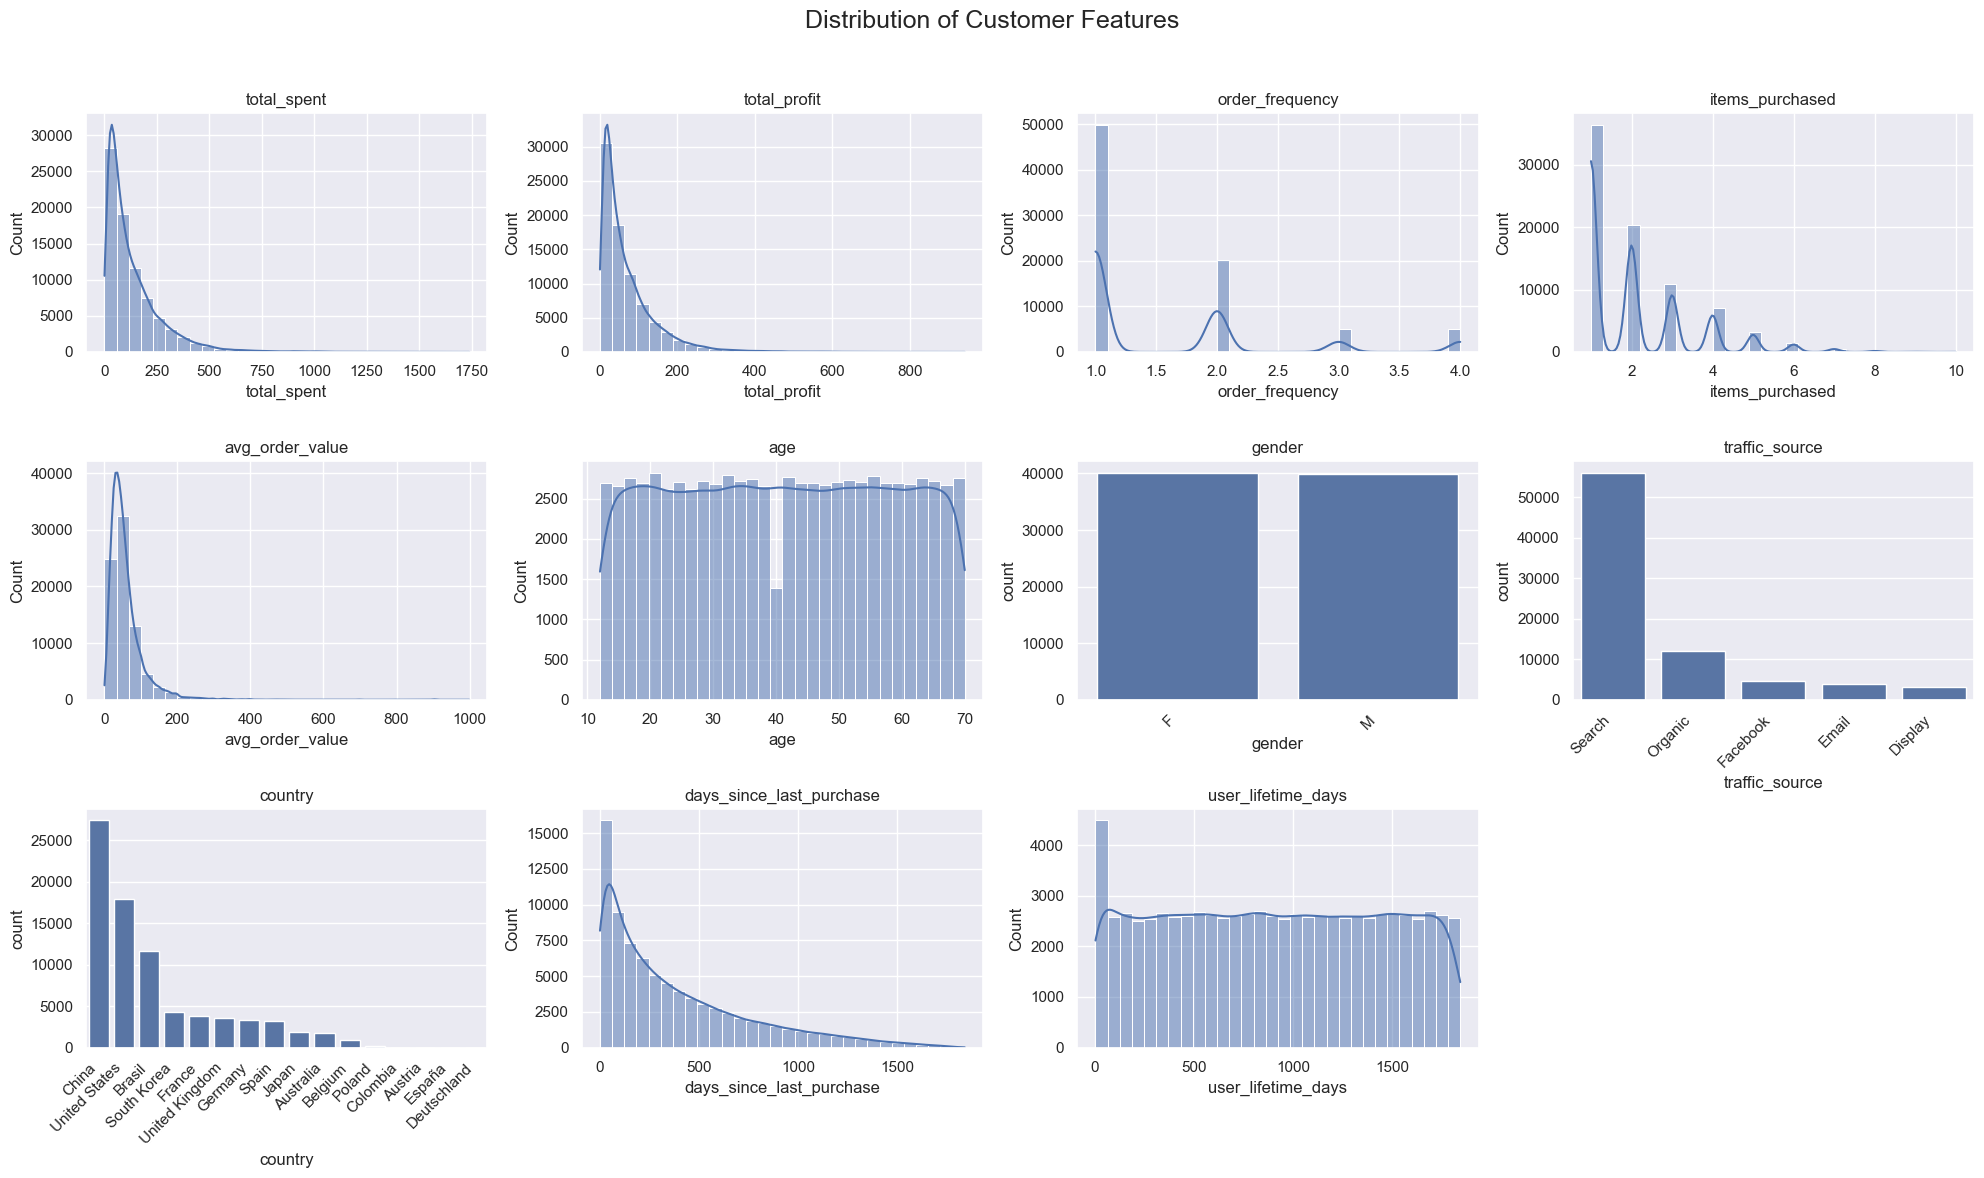

In [48]:
fig, axs = plt.subplots(3, 4, figsize=(20, 12))
fig.suptitle('Distribution of Customer Features', fontsize=18)

# List of columns to plot
columns = [
    'total_spent', 'total_profit', 'order_frequency', 'items_purchased',
    'avg_order_value', 'age', 'gender', 'traffic_source',
    'country', 'days_since_last_purchase', 'user_lifetime_days'
]

for i, col in enumerate(columns):
    ax = axs[i // 4, i % 4]
    if customer_df[col].dtype == 'object':
        sns.countplot(data=customer_df, x=col, ax=ax, order=customer_df[col].value_counts().index)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    else:
        sns.histplot(customer_df[col], bins=30, kde=True, ax=ax)
    ax.set_title(col)

# Hide the last subplot if not used
if len(columns) < 12:
    for j in range(len(columns), 12):
        axs[j // 4, j % 4].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 2.1 Customer Data Visualization

Visualize customer features to understand distributions and identify patterns.

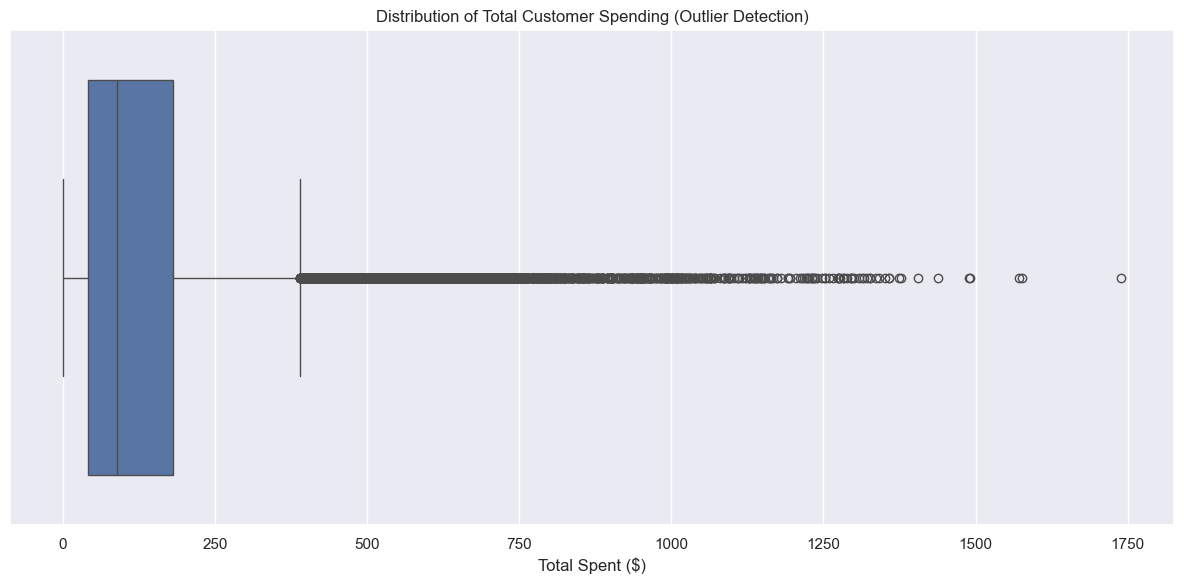

In [49]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=customer_df, x="total_spent")
plt.title('Distribution of Total Customer Spending (Outlier Detection)')
plt.xlabel('Total Spent ($)')
plt.tight_layout()
plt.show()

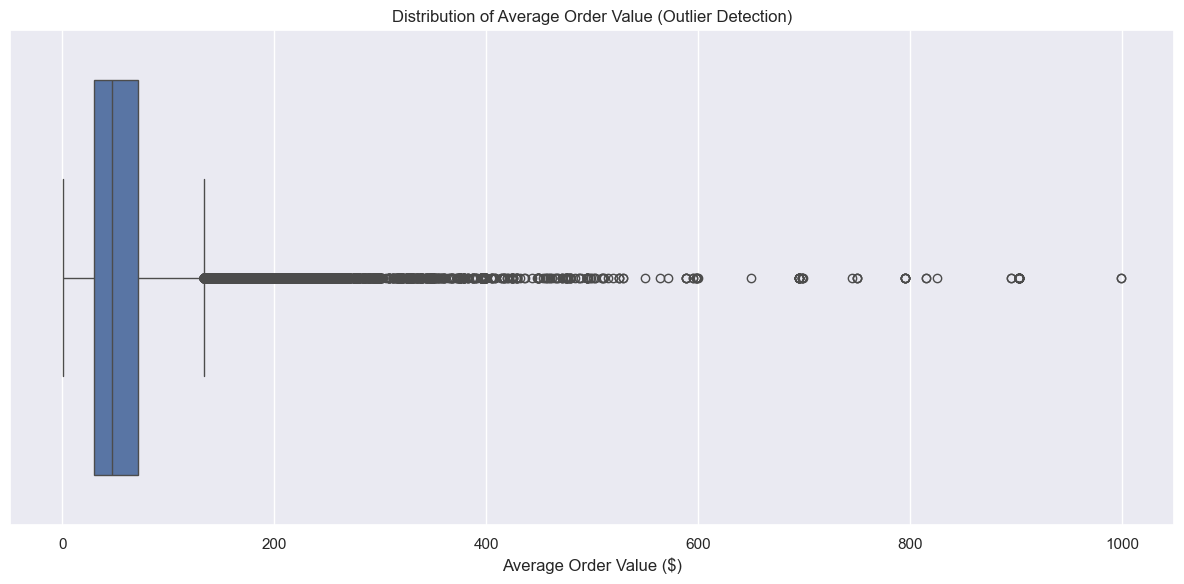

In [50]:
# Analyze distribution and outliers in average order value
plt.figure(figsize=(12, 6))
sns.boxplot(data=customer_df, x="avg_order_value")
plt.title('Distribution of Average Order Value (Outlier Detection)')
plt.xlabel('Average Order Value ($)')
plt.tight_layout()
plt.show()

In [51]:
# Detect outliers using IQR method for total spending
Q1 = customer_df['total_spent'].quantile(0.25)
Q3 = customer_df['total_spent'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers (customers with spending > Q3 + 1.5*IQR)
outlier_threshold = Q3 + 1.5 * IQR
customer_outliers = customer_df[customer_df['total_spent'] > outlier_threshold]

print(f"📊 Outlier Analysis:")
print(f"Q1: ${Q1:.2f}")
print(f"Q3: ${Q3:.2f}")
print(f"IQR: ${IQR:.2f}")
print(f"Outlier threshold: ${outlier_threshold:.2f}")
print(f"Number of outliers: {len(customer_outliers)} ({len(customer_outliers)/len(customer_df)*100:.1f}%)")

# Display top outliers
customer_outliers.head()

📊 Outlier Analysis:
Q1: $41.29
Q3: $180.99
IQR: $139.70
Outlier threshold: $390.54
Number of outliers: 4279 (5.3%)


,users_id,total_spent,total_profit,avg_order_value,order_frequency,items_purchased,age,gender,traffic_source,country,days_since_last_purchase,user_lifetime_days,no_return,no_cancel,no_complete,no_shipped,no_process
2,3,402.200001,205.346420,80.440000,4,5,16,M,Organic,United States,166,318,0,0,2,1,2
8,9,543.489986,290.560652,90.581664,2,6,39,M,Organic,China,76,1626,0,6,0,0,0
14,17,747.989986,397.133581,106.855712,3,6,29,M,Search,United Kingdom,1177,1730,0,0,6,1,0
35,43,412.430000,217.622230,45.825556,3,6,31,F,Search,China,202,851,0,0,5,0,4
92,119,475.890015,279.404968,118.972504,2,4,37,M,Search,China,431,879,0,0,0,0,4


## 2.2 Outlier Detection and Handling

Identify and handle outliers in customer spending data using the IQR method.

In [52]:
# Create dataset without outliers for more stable clustering
customer_non_outlier_df = customer_df[~customer_df.index.isin(customer_outliers.index)]
print(f"✅ Created non-outlier dataset with {len(customer_non_outlier_df)} customers")
print(f"📊 Removed {len(customer_outliers)} outliers ({len(customer_outliers)/len(customer_df)*100:.1f}% of data)")

✅ Created non-outlier dataset with 75765 customers
📊 Removed 4279 outliers (5.3% of data)


In [53]:
# Prepare data for clustering - select features and encode categorical variables
features_for_clustering = customer_df.drop('users_id', axis=1)
categorical_cols = ['gender', 'traffic_source', 'country']

# One-hot encode categorical features
features_encoded = pd.get_dummies(features_for_clustering, columns=categorical_cols, drop_first=True)

print("✅ Data prepared for clustering:")
print(f"Original features: {len(features_for_clustering.columns)}")
print(f"Encoded features: {len(features_encoded.columns)}")
print(f"Dataset shape: {features_encoded.shape}")


✅ Data prepared for clustering:
Original features: 16
Encoded features: 33
Dataset shape: (80044, 33)


# 3. Customer Clustering Analysis

This section prepares data for clustering and applies K-Means clustering to segment customers.

✅ Data scaled and ready for clustering.

--- Finding the Optimal Number of Clusters (Elbow Method) ---


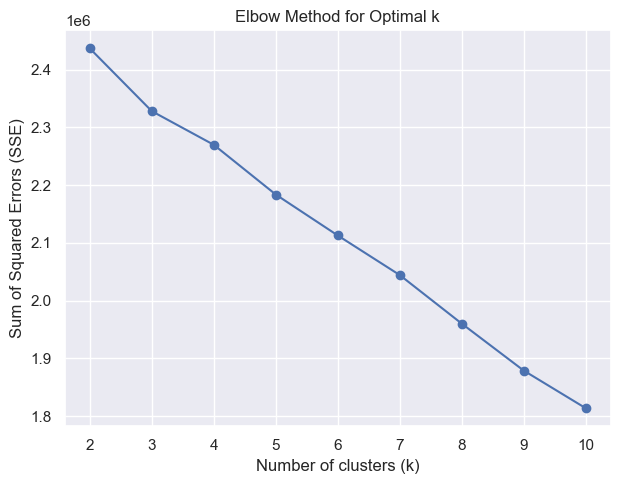

✅ Based on the elbow plot, proceeding with k=4 clusters.

--- Applying K-Means Clustering with 4 Clusters ---
✅ Clustering complete. 'cluster' column added to the customer dataframe.


In [54]:
# Scale numerical features for clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_encoded)
print("✅ Data scaled and ready for clustering.")

# Determine optimal number of clusters using Elbow Method
print("\n--- Finding the Optimal Number of Clusters (Elbow Method) ---")

sse = []
k_range = range(2, 11)  # silhouette score is not defined for k=1

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    sse.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(list(k_range), sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Choose optimal number of clusters
optimal_k = 4
print(f"✅ Based on the elbow plot, proceeding with k={optimal_k} clusters.")

# Apply K-Means Clustering
print(f"\n--- Applying K-Means Clustering with {optimal_k} Clusters ---")
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=1000, n_init=10, random_state=42)
customer_df['cluster'] = kmeans.fit_predict(scaled_features)
print("✅ Clustering complete. 'cluster' column added to the customer dataframe.")




## 4.1 Cluster Visualization and Analysis

Visualize the clustering results and analyze cluster characteristics.

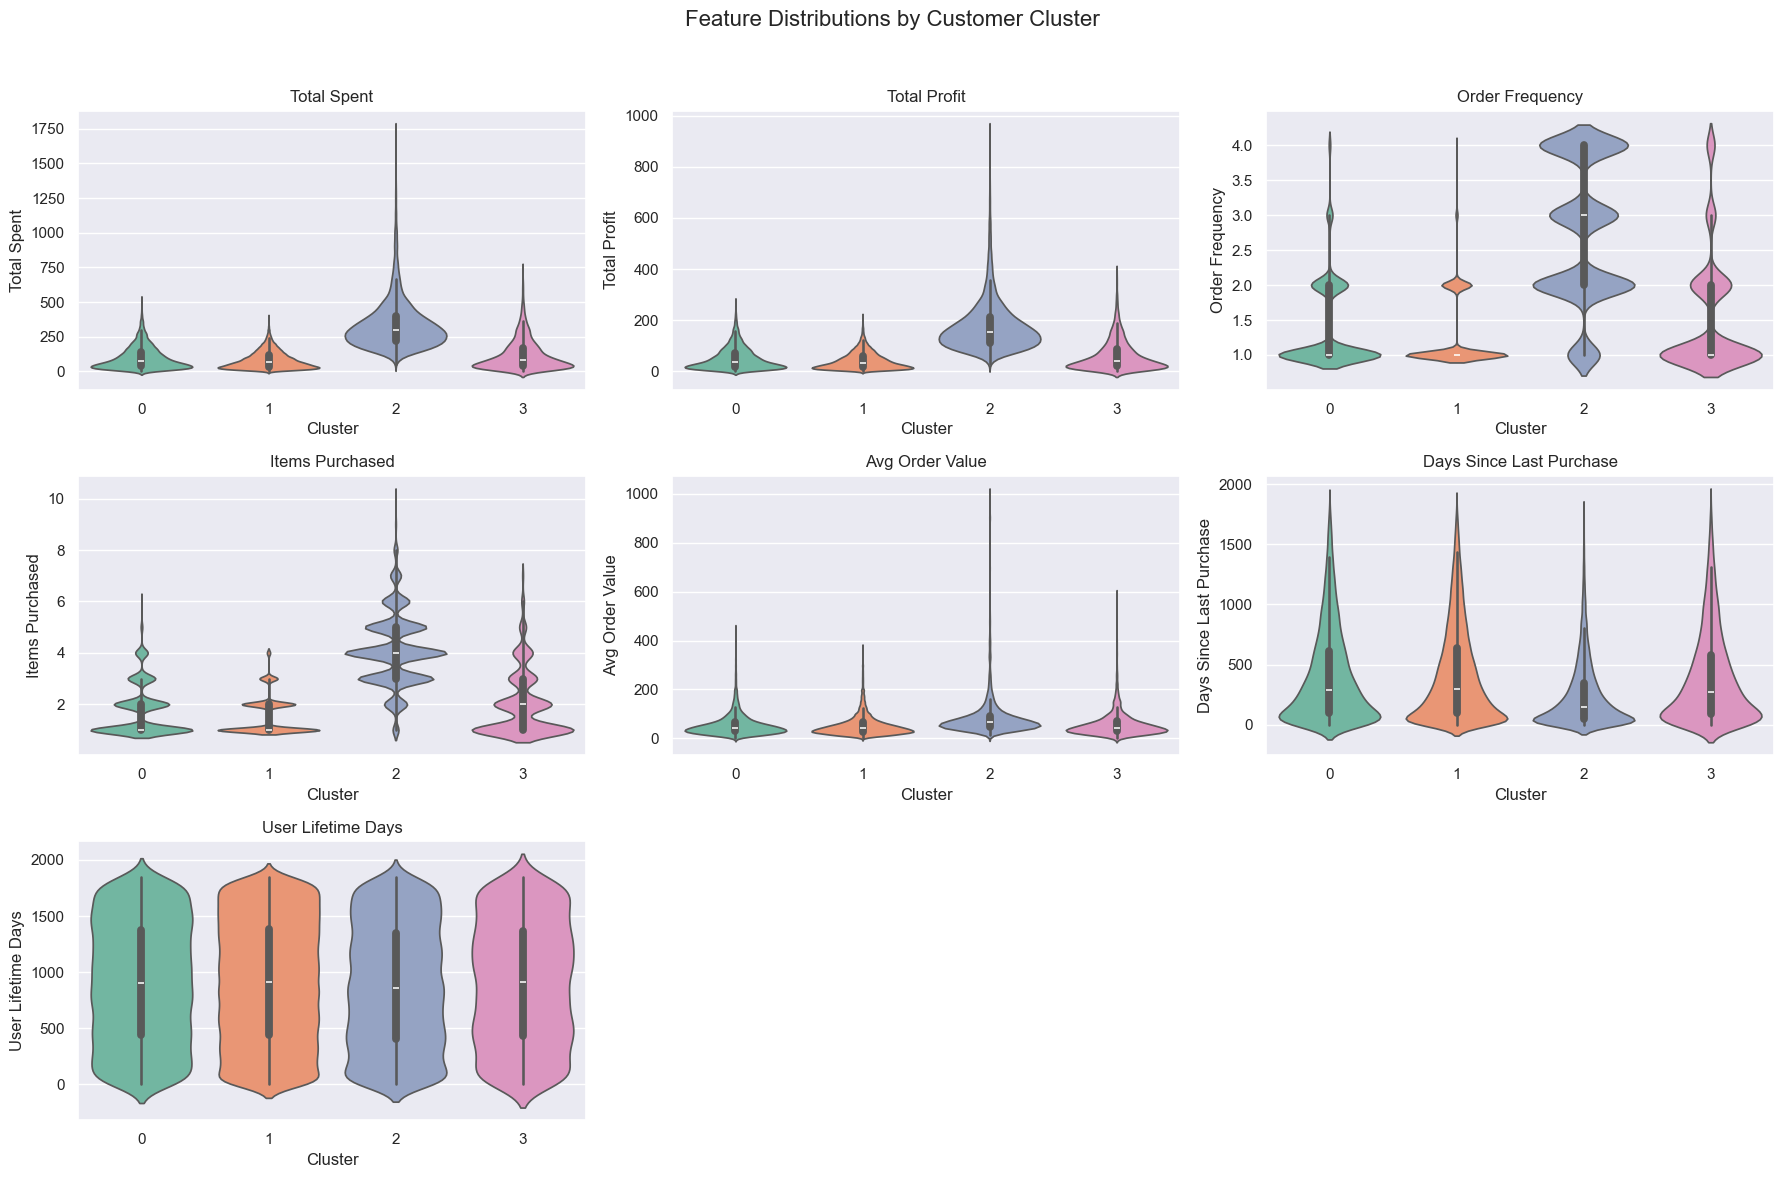

In [55]:
# Create violin plots to show distribution of key features by cluster
columns_to_plot = [
    'total_spent', 'total_profit', 'order_frequency', 'items_purchased',
    'avg_order_value', 'days_since_last_purchase', 'user_lifetime_days'
]

fig, axs = plt.subplots(nrows=(len(columns_to_plot) + 2) // 3, ncols=3, figsize=(18, 12))
fig.suptitle('Feature Distributions by Customer Cluster', fontsize=16)

for i, col in enumerate(columns_to_plot):
    ax = axs[i // 3, i % 3]
    sns.violinplot(
        x=customer_df['cluster'], 
        y=customer_df[col], 
        hue=customer_df['cluster'], 
        ax=ax, 
        palette='Set2', 
        legend=False
    )
    ax.set_title(col.replace('_', ' ').title())
    ax.set_xlabel('Cluster')
    ax.set_ylabel(col.replace('_', ' ').title())

# Hide any unused subplots
for j in range(len(columns_to_plot), axs.size):
    axs.flat[j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

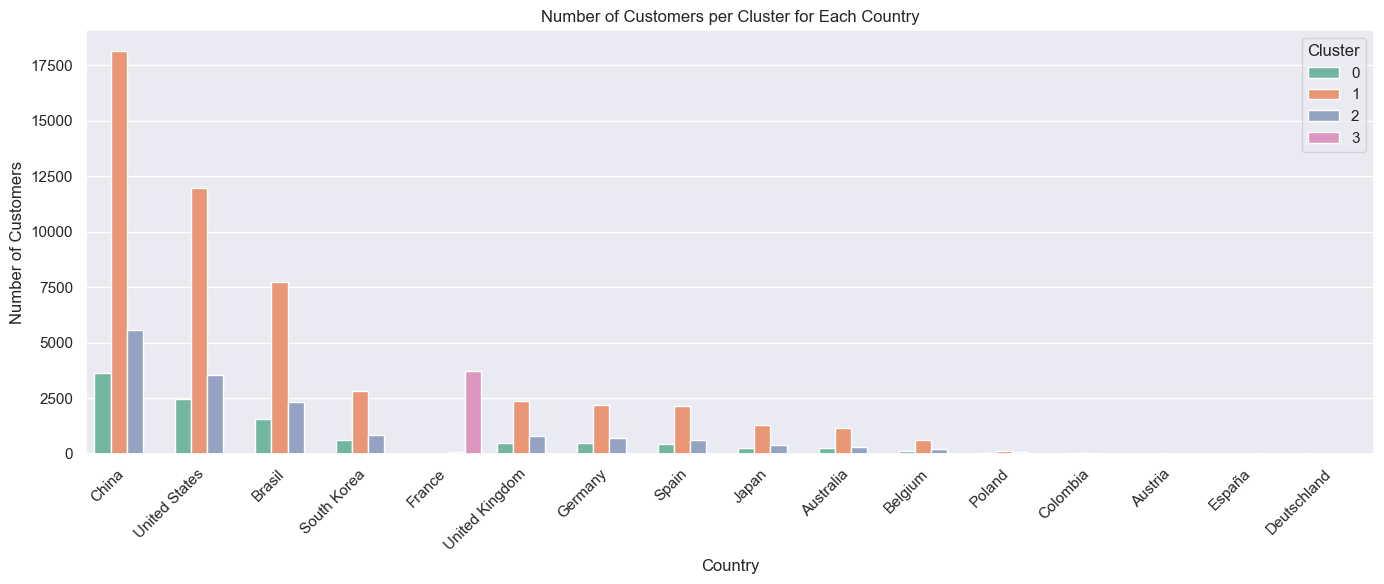

In [56]:
plt.figure(figsize=(14, 6))
sns.countplot(data=customer_df, x='country', hue='cluster', order=customer_df['country'].value_counts().index,palette='Set2')
plt.title('Number of Customers per Cluster for Each Country')
plt.xlabel('Country')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()